## Data files 

mofid_test.cvs/.json - normalized dictionary of MOFid

test.csv/.json - normalized all data (mofid, mofkey, space group, cell parameter, organic linker, metal node and etc.)

func.py - script for normalization raw data 

In [15]:
import pandas as pd 

# Import comet_ml at the top of your file
# from comet_ml import Experiment

import os
import numpy as np
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


## Data preparing 

In [2]:
# Import the dataset and split it into train and test
data = pd.read_csv('03_04_prepare.csv', index_col=0)
train_dataset, test_dataset = train_test_split(data, test_size=0.2)


In [3]:
train_dataset

,simples_nodes,simples_linkers,simples,topology,cat,a,b,c,alpha,beta,gamma,cell volume,space group
cifname,,,,,,,,,,,,,
7108220,0.840194,0.819767,0.818988,0.190045,0.000000,0.140592,0.118113,0.137548,0.515868,0.524009,0.480222,0.005158,0.085366
7120552,0.881356,0.866279,0.866903,0.262443,0.142857,0.194836,0.412542,0.440542,0.515868,0.354983,0.480222,0.057495,0.384146
4515120,0.036320,0.024419,0.181012,0.185520,0.000000,0.091119,0.073679,0.095902,0.515868,0.373437,0.480222,0.001844,0.048780
7105622,0.823245,0.801163,0.799468,0.190045,0.000000,0.080996,0.086758,0.072600,0.603268,0.678523,0.647695,0.001295,0.060976
7125416,0.036320,0.882558,0.882875,0.954751,0.142857,0.285982,0.334634,0.195092,0.515868,0.354983,0.480222,0.031842,0.713415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347732,0.145278,0.576744,0.551020,0.307692,0.000000,0.085396,0.112215,0.169489,0.515868,0.668848,0.480222,0.003771,0.054878
7710103,0.365617,0.073256,0.989352,0.429864,0.000000,0.325897,0.326043,0.315362,0.515868,0.354983,1.000000,0.046120,0.036585
4507948,0.145278,0.602326,0.584738,0.199095,0.000000,0.086850,0.146202,0.177930,0.515868,0.354983,0.480222,0.005404,0.274390


In [4]:
# Convert the data to tensors
train_dataset = tf.convert_to_tensor(train_dataset.to_numpy())
test_dataset = tf.convert_to_tensor(test_dataset.to_numpy())

## Variational autoencoder

In [9]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(13,)),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5, name = 'dropout1'),
            tf.keras.layers.Dense(32, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5, name = 'dropout2'),
            tf.keras.layers.Dense(latent_dim*2),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation=tf.nn.relu),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(13)
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def call(self, inputs, training=None):
    """Training is a boolean variable indicating whether the model is in training mode or not.
    
    When training=True, the model will apply dropout, batch normalization, or any other operations of the training phase. 
    When training=False, the model will not apply these operations and will be suitable for making predictions.
    """
    if training is None:
        training = tf.keras.backend.learning_phase()

    mean, logvar = self.encode(inputs)
    z = self.reparameterize(mean, logvar)
    reconstructed = self.decode(z)
    return reconstructed
  
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


In [6]:
# What 
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# Compute loss function (in this case - ELBO)
def compute_loss(model, x):
  # Check input shape
  if len(x.shape) == 1:
    x = tf.expand_dims(x, axis=0)
  
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  x = tf.cast(x, dtype=tf.float32)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent)
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# Compute gradients and update parameters
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  # x = tf.expand_dims(x, axis=1)
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [22]:
# Introduce model and optimizer
latent_dim = 2
epochs = 50
model = CVAE(2)
optimizer = tf.keras.optimizers.Adam(1e-4)
checkpoint_dir = "./checkpoints"
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [23]:
# Build the model and optimizer for the first time
# It is necessary to build the model and optimizer before
# training due to @tf.function in train_step 
sample_batch = next(iter(train_dataset))
sample_batch = tf.expand_dims(sample_batch, axis=0)
_ = model(sample_batch, training=True)  # Build the model
optimizer.build(model.trainable_variables)  # Build the optimizer

In [24]:
# Define the metrics
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

# Store the losses for each epoch
train_elbo_history = []
test_elbo_history = []

for epoch in range(1, epochs + 1):
    start_time = time.time()

    # Training loop
    for train_x in train_dataset:
        train = tf.expand_dims(train_x, axis=0)
        train_loss = train_step(model, train, optimizer)
        train_loss_metric(train_loss)

    # Evaluation loop
    for test_x in test_dataset:
        test_loss = compute_loss(model, test_x)
        test_loss_metric(test_loss)

    end_time = time.time()
    
    # Calculate the ELBO
    train_elbo = -train_loss_metric.result()
    test_elbo = -test_loss_metric.result()

    # Print results
    print("\n" + "-" * 50)
    print(f'Epoch: {epoch}, Train ELBO: {train_elbo}, Test ELBO: {test_elbo}, time elapsed for current epoch: {end_time - start_time}')

    # Save a checkpoint
    manager.save()

    # Store the losses for each epoch
    train_elbo_history.append(train_elbo)
    test_elbo_history.append(test_elbo)
    
    # Reset metrics at the end of each epoch
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()


--------------------------------------------------
Epoch: 1, Train ELBO: -7.908021926879883, Test ELBO: -7.023890495300293, time elapsed for current epoch: 8.759373903274536

--------------------------------------------------
Epoch: 2, Train ELBO: -6.956078052520752, Test ELBO: -6.844833850860596, time elapsed for current epoch: 8.211919069290161

--------------------------------------------------
Epoch: 3, Train ELBO: -6.895493507385254, Test ELBO: -6.864378452301025, time elapsed for current epoch: 7.43080472946167

--------------------------------------------------
Epoch: 4, Train ELBO: -6.872354984283447, Test ELBO: -6.838998794555664, time elapsed for current epoch: 7.062342882156372

--------------------------------------------------
Epoch: 5, Train ELBO: -6.84921932220459, Test ELBO: -6.8002448081970215, time elapsed for current epoch: 7.0610082149505615

--------------------------------------------------
Epoch: 6, Train ELBO: -6.842427730560303, Test ELBO: -6.80867862701416, t

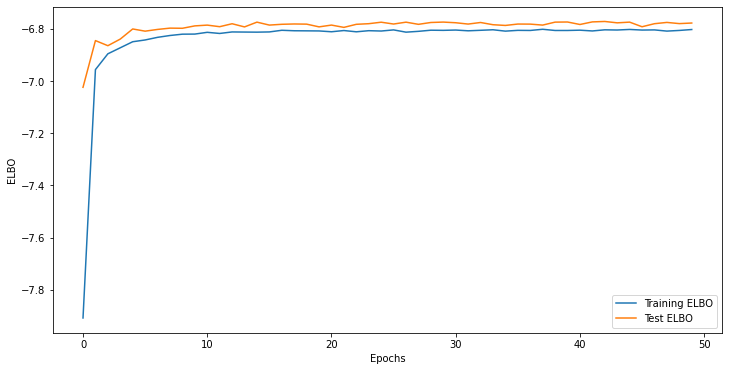

In [25]:
# Plot the ELBO for check overfitting
plt.figure(figsize=(12, 6))
plt.plot(train_elbo_history, label='Training ELBO')
plt.plot(test_elbo_history, label='Test ELBO')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.show()

In [ ]:
# Grisha, we need to write the encryptor function from the data obtained at the output of the neuron after its training 

### Saving model 

In [ ]:
sample_batch = next(iter(train_dataset))
sample_batch = tf.expand_dims(sample_batch, axis=0)
# _ = model(sample_batch)
sample_batch

In [ ]:
# Save the model weights
model.save_weights('./saved weights/model_save')

In [ ]:
# Before we can use the model, we need to create an instance of the same model.
loaded_model = CVAE(2)
loaded_model.load_weights('./saved weights/model_save')

# Check its architecture
loaded_model.summary()


,mofid,mofkey,simples_nodes,simples_linkers,simples,topology,cat,_cell_length_a,_cell_length_b,_cell_length_c,_cell_angle_alpha,_cell_angle_beta,_cell_angle_gamma,_cell_volume,_symmetry_space_group_name_Hall
cifname,,,,,,,,,,,,,,,
1100140,Cl[Cu]O[Cu]O[Cu]Cl.O=[C]1=NC=CC=N1.n1ccc(cc1)c...,Cu.BSACTHHIMKWVLX.MWVTWFVJZLCBMC.MOFkey-v1.hxl,['Cl[Cu]O[Cu]O[Cu]Cl'],"['O=[C]1=NC=CC=N1', 'n1ccc(cc1)c1ccncc1']",Cl[Cu]O[Cu]O[Cu]Cl.O=[C]1=NC=CC=N1.n1ccc(cc1)c...,hxl,1.0,17.0760,19.3410,13.4810,90.00,90.000,90.000,4452.30,P 2 -2n
1100722,[Fe][O]([Fe])[Fe].[O-]C(=O)c1ccc(cc1)C(=O)[O-]...,Fe.KKEYFWRCBNTPAC.MOFkey-v1.acs,['[Fe][O]([Fe])[Fe]'],['[O-]C(=O)c1ccc(cc1)C(=O)[O-]'],[Fe][O]([Fe])[Fe].[O-]C(=O)c1ccc(cc1)C(=O)[O-],acs,0.0,12.5310,12.5310,18.4760,90.00,90.000,120.000,2512.50,P -6c -2c
1501627,[In].[O-]C(=O)C1=C[C]=CC(=C1)C(=O)[O-] MOFid-v...,In.GZJYHAYPVZNUJX.MOFkey-v1.sql,['[In]'],['[O-]C(=O)C1=C[C]=CC(=C1)C(=O)[O-]'],[In].[O-]C(=O)C1=C[C]=CC(=C1)C(=O)[O-],sql,1.0,9.9532,9.9532,26.7005,90.00,90.000,90.000,2645.12,-P 4c 2
1501629,[In].[O-]C(=O)c1cc(cc(c1)C(=O)[O-])c1c(F)c(F)c...,In.TYPODEXFRPHZNH.MOFkey-v1.pts,['[In]'],['[O-]C(=O)c1cc(cc(c1)C(=O)[O-])c1c(F)c(F)c(c(...,[In].[O-]C(=O)c1cc(cc(c1)C(=O)[O-])c1c(F)c(F)c...,"pts,tfi",0.0,19.8070,19.8070,53.4540,90.00,90.000,90.000,20971.00,-I 4bd 2c
1501771,[O-]C(=O)c1cc(cc(c1)C(=O)[O-])C(=O)[O-].[O][Zn...,Zn.QMKYBPDZANOJGF.MOFkey-v1.tbo,['[O][Zn][Zn][O]'],['[O-]C(=O)c1cc(cc(c1)C(=O)[O-])C(=O)[O-]'],[O-]C(=O)c1cc(cc(c1)C(=O)[O-])C(=O)[O-].[O][Zn...,tbo,0.0,26.4461,26.4461,26.4461,90.00,90.000,90.000,18496.30,-F 4 2 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8000359,C1CN2CCN1CC2.[O-]C(=O)c1ccc(cc1)C(=O)[O-].[OH4...,Co.IMNIMPAHZVJRPE.KKEYFWRCBNTPAC.MOFkey-v1.sql,['[OH4][Co]'],"['C1CN2CCN1CC2', '[O-]C(=O)c1ccc(cc1)C(=O)[O-]']",C1CN2CCN1CC2.[O-]C(=O)c1ccc(cc1)C(=O)[O-].[OH4...,sql,0.0,6.0947,7.0901,10.6768,90.00,95.090,90.000,459.55,P -2y
8000369,C1CN2CCN1CC2.[O-]C(=O)c1ccc(cc1)C(=O)[O-].[O][...,Co.IMNIMPAHZVJRPE.KKEYFWRCBNTPAC.MOFkey-v1.sql,['[O][Co]'],"['C1CN2CCN1CC2', '[O-]C(=O)c1ccc(cc1)C(=O)[O-]']",C1CN2CCN1CC2.[O-]C(=O)c1ccc(cc1)C(=O)[O-].[O][Co],sql,0.0,6.0764,7.0959,10.7040,90.00,95.196,90.000,459.63,P -2y
8000378,[C]1CN2CCN1CC2.[O-]C(=O)c1ccc(cc1)C(=O)[O-].[O...,Co.HSRAEJMOSDMCJG.KKEYFWRCBNTPAC.MOFkey-v1.sql,['[OH2][Co]'],"['[C]1CN2CCN1CC2', '[O-]C(=O)c1ccc(cc1)C(=O)[O...",[C]1CN2CCN1CC2.[O-]C(=O)c1ccc(cc1)C(=O)[O-].[O...,sql,0.0,5.8426,7.0452,10.5850,90.43,96.620,94.933,431.13,P 1


### One-hot encoding via Pandas lib

In [79]:
raw_data = pd.read_csv(f'D:\github repo\MOF_ML\\token_part\\5k_with_symmetry.csv', index_col=0)

In [80]:
# remove the mofid and mofkey columns
raw_data = raw_data.drop(columns=['mofid','mofkey'])

In [81]:
# rename columns in raw_data
raw_data = raw_data.rename(columns={'simples_nodes': 'nodes', 'simples_linkers':'linkers', 
       '_cell_length_a': 'a', '_cell_length_b': 'b', '_cell_length_c': 'c',
       '_cell_angle_alpha': 'alpha', '_cell_angle_beta': 'beta', '_cell_angle_gamma': 'gamma',
       '_cell_volume': 'cell volume', '_symmetry_space_group_name_Hall': 'space group'})

In [82]:
raw_data

,nodes,linkers,simples,topology,cat,a,b,c,alpha,beta,gamma,cell volume,space group
cifname,,,,,,,,,,,,,
1100140,['Cl[Cu]O[Cu]O[Cu]Cl'],"['O=[C]1=NC=CC=N1', 'n1ccc(cc1)c1ccncc1']",Cl[Cu]O[Cu]O[Cu]Cl.O=[C]1=NC=CC=N1.n1ccc(cc1)c...,hxl,1.0,17.0760,19.3410,13.4810,90.00,90.000,90.000,4452.30,P 2 -2n
1100722,['[Fe][O]([Fe])[Fe]'],['[O-]C(=O)c1ccc(cc1)C(=O)[O-]'],[Fe][O]([Fe])[Fe].[O-]C(=O)c1ccc(cc1)C(=O)[O-],acs,0.0,12.5310,12.5310,18.4760,90.00,90.000,120.000,2512.50,P -6c -2c
1501627,['[In]'],['[O-]C(=O)C1=C[C]=CC(=C1)C(=O)[O-]'],[In].[O-]C(=O)C1=C[C]=CC(=C1)C(=O)[O-],sql,1.0,9.9532,9.9532,26.7005,90.00,90.000,90.000,2645.12,-P 4c 2
1501629,['[In]'],['[O-]C(=O)c1cc(cc(c1)C(=O)[O-])c1c(F)c(F)c(c(...,[In].[O-]C(=O)c1cc(cc(c1)C(=O)[O-])c1c(F)c(F)c...,"pts,tfi",0.0,19.8070,19.8070,53.4540,90.00,90.000,90.000,20971.00,-I 4bd 2c
1501771,['[O][Zn][Zn][O]'],['[O-]C(=O)c1cc(cc(c1)C(=O)[O-])C(=O)[O-]'],[O-]C(=O)c1cc(cc(c1)C(=O)[O-])C(=O)[O-].[O][Zn...,tbo,0.0,26.4461,26.4461,26.4461,90.00,90.000,90.000,18496.30,-F 4 2 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8000359,['[OH4][Co]'],"['C1CN2CCN1CC2', '[O-]C(=O)c1ccc(cc1)C(=O)[O-]']",C1CN2CCN1CC2.[O-]C(=O)c1ccc(cc1)C(=O)[O-].[OH4...,sql,0.0,6.0947,7.0901,10.6768,90.00,95.090,90.000,459.55,P -2y
8000369,['[O][Co]'],"['C1CN2CCN1CC2', '[O-]C(=O)c1ccc(cc1)C(=O)[O-]']",C1CN2CCN1CC2.[O-]C(=O)c1ccc(cc1)C(=O)[O-].[O][Co],sql,0.0,6.0764,7.0959,10.7040,90.00,95.196,90.000,459.63,P -2y
8000378,['[OH2][Co]'],"['[C]1CN2CCN1CC2', '[O-]C(=O)c1ccc(cc1)C(=O)[O...",[C]1CN2CCN1CC2.[O-]C(=O)c1ccc(cc1)C(=O)[O-].[O...,sql,0.0,5.8426,7.0452,10.5850,90.43,96.620,94.933,431.13,P 1


Divide dataset on parts which we merge in the end after one-hot encoding and normalization.

\bold{Nodes, linkers, simples, topology, space group} - applied one-hot encoding for nominal categorical variables

a, b, c, alpha, beta, gamma, cell volume - normalization 

In [83]:
class preprocessingData():
    """ 
    Preprocessing data for neural network
     
    Parameters: data - pandas dataframe
                scaler - sklearn scaler
    """
    def __init__(self, data, scaler=None):
        self.data = data
        if scaler==None:
            self.scaler = StandardScaler()
    
    # normalization of numerical data
    def normalization(self):
        numerical = self.data.select_dtypes(include=[pd.np.number])
        data_local = self.scaler.fit_transform(numerical)
        return pd.DataFrame(data_local, columns=numerical.columns, index=numerical.index)
    
    # inverse normalization of numerical data
    def inverseNormalization(self, data):
        data_local = self.scaler.inverse_transform(data)
        return pd.DataFrame(data_local, columns=data.columns, index=data.index)
    
    # one hot encoding of categorical data
    def oneHotEncoding(self):
        data_normalized = self.normalization()
        categorical = self.data.select_dtypes(include=[pd.np.object])
        for x in categorical.columns:
            one_hot_data = pd.get_dummies(categorical[x])
            data_normalized = pd.concat([data_normalized, one_hot_data], axis='columns')
        return data_normalized

In [84]:
test_class = preprocessingData(raw_data)
test_data = test_class.oneHotEncoding()
test_data

C:\Users\schir\AppData\Local\Temp/ipykernel_3324/2633171121.py:15: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  numerical = self.data.select_dtypes(include=[pd.np.number])
C:\Users\schir\AppData\Local\Temp/ipykernel_3324/2633171121.py:27: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  categorical = self.data.select_dtypes(include=[pd.np.object])
C:\Users\schir\AppData\Local\Temp/ipykernel_3324/2633171121.py:27: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical = self.data.select_dtypes(include=[pd.np.object])


,cat,a,b,c,alpha,beta,gamma,cell volume,"['', '[O][Cu][Cu][O]']",['*[O]12[Zr]345678[O]9[Zr]%10%11%12%13%141[O]15([O]8%10[Zr]58%10%15%161[O]14([O]65[Zr]456%17%181[O]13([Zr]3%19%2029([O]741)[O]1%12([O]%143[Zr]231([O]%118([O]%13%102)*)([O]5%19([O]6%203)*)([O]%15%17)[O]%16%18*)*)*)*)*'],...,P 64 2 (0 0 2),P 65 2 (0 0 1),P 6c,P 6c -2,P 6c -2c,P 6c 2c,R 3,"R 3 -2""","R 3 -2""c","R 3 2"""
cifname,,,,,,,,,,,,,,,,,,,,,
1100140,0.565534,-0.211289,-0.046857,-0.628971,-0.010315,-0.495260,-0.353838,-0.258677,0,0,...,0,0,0,0,0,0,0,0,0,0
1100722,-0.531025,-0.666750,-0.747636,-0.232269,-0.010315,-0.495260,2.470360,-0.326871,0,0,...,0,0,0,0,0,0,0,0,0,0
1501627,0.565534,-0.925076,-1.012903,0.420918,-0.010315,-0.495260,-0.353838,-0.322209,0,0,...,0,0,0,0,0,0,0,0,0,0
1501629,-0.531025,0.062389,0.001096,2.545673,-0.010315,-0.495260,-0.353838,0.322040,0,0,...,0,0,0,0,0,0,0,0,0,0
1501771,-0.531025,0.727704,0.684289,0.400714,-0.010315,-0.495260,-0.353838,0.235042,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8000359,-0.531025,-1.311742,-1.307529,-0.851679,-0.010315,0.001363,-0.353838,-0.399043,0,0,...,0,0,0,0,0,0,0,0,0,0
8000369,-0.531025,-1.313576,-1.306932,-0.849519,-0.010315,0.011706,-0.353838,-0.399040,0,0,...,0,0,0,0,0,0,0,0,0,0
8000378,-0.531025,-1.337006,-1.312149,-0.858970,0.075788,0.150643,0.110555,-0.400042,0,0,...,0,0,0,0,0,0,0,0,0,0
